## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

%pip install -q git+https://github.com/huggingface/transformers.git

In [10]:
%pip install -q datasets sentencepiece

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load image

In [ ]:
import os
from huggingface_hub import login

HUGGING_FACE_TOKEN = os.getenv("HUGGING_FACE_TOKEN")
print("HF Token:", HUGGING_FACE_TOKEN)   
login(token=HUGGING_FACE_TOKEN)

In [14]:
from datasets import load_dataset

dataset = load_dataset("katanaml-org/invoices-donut-data-v1")

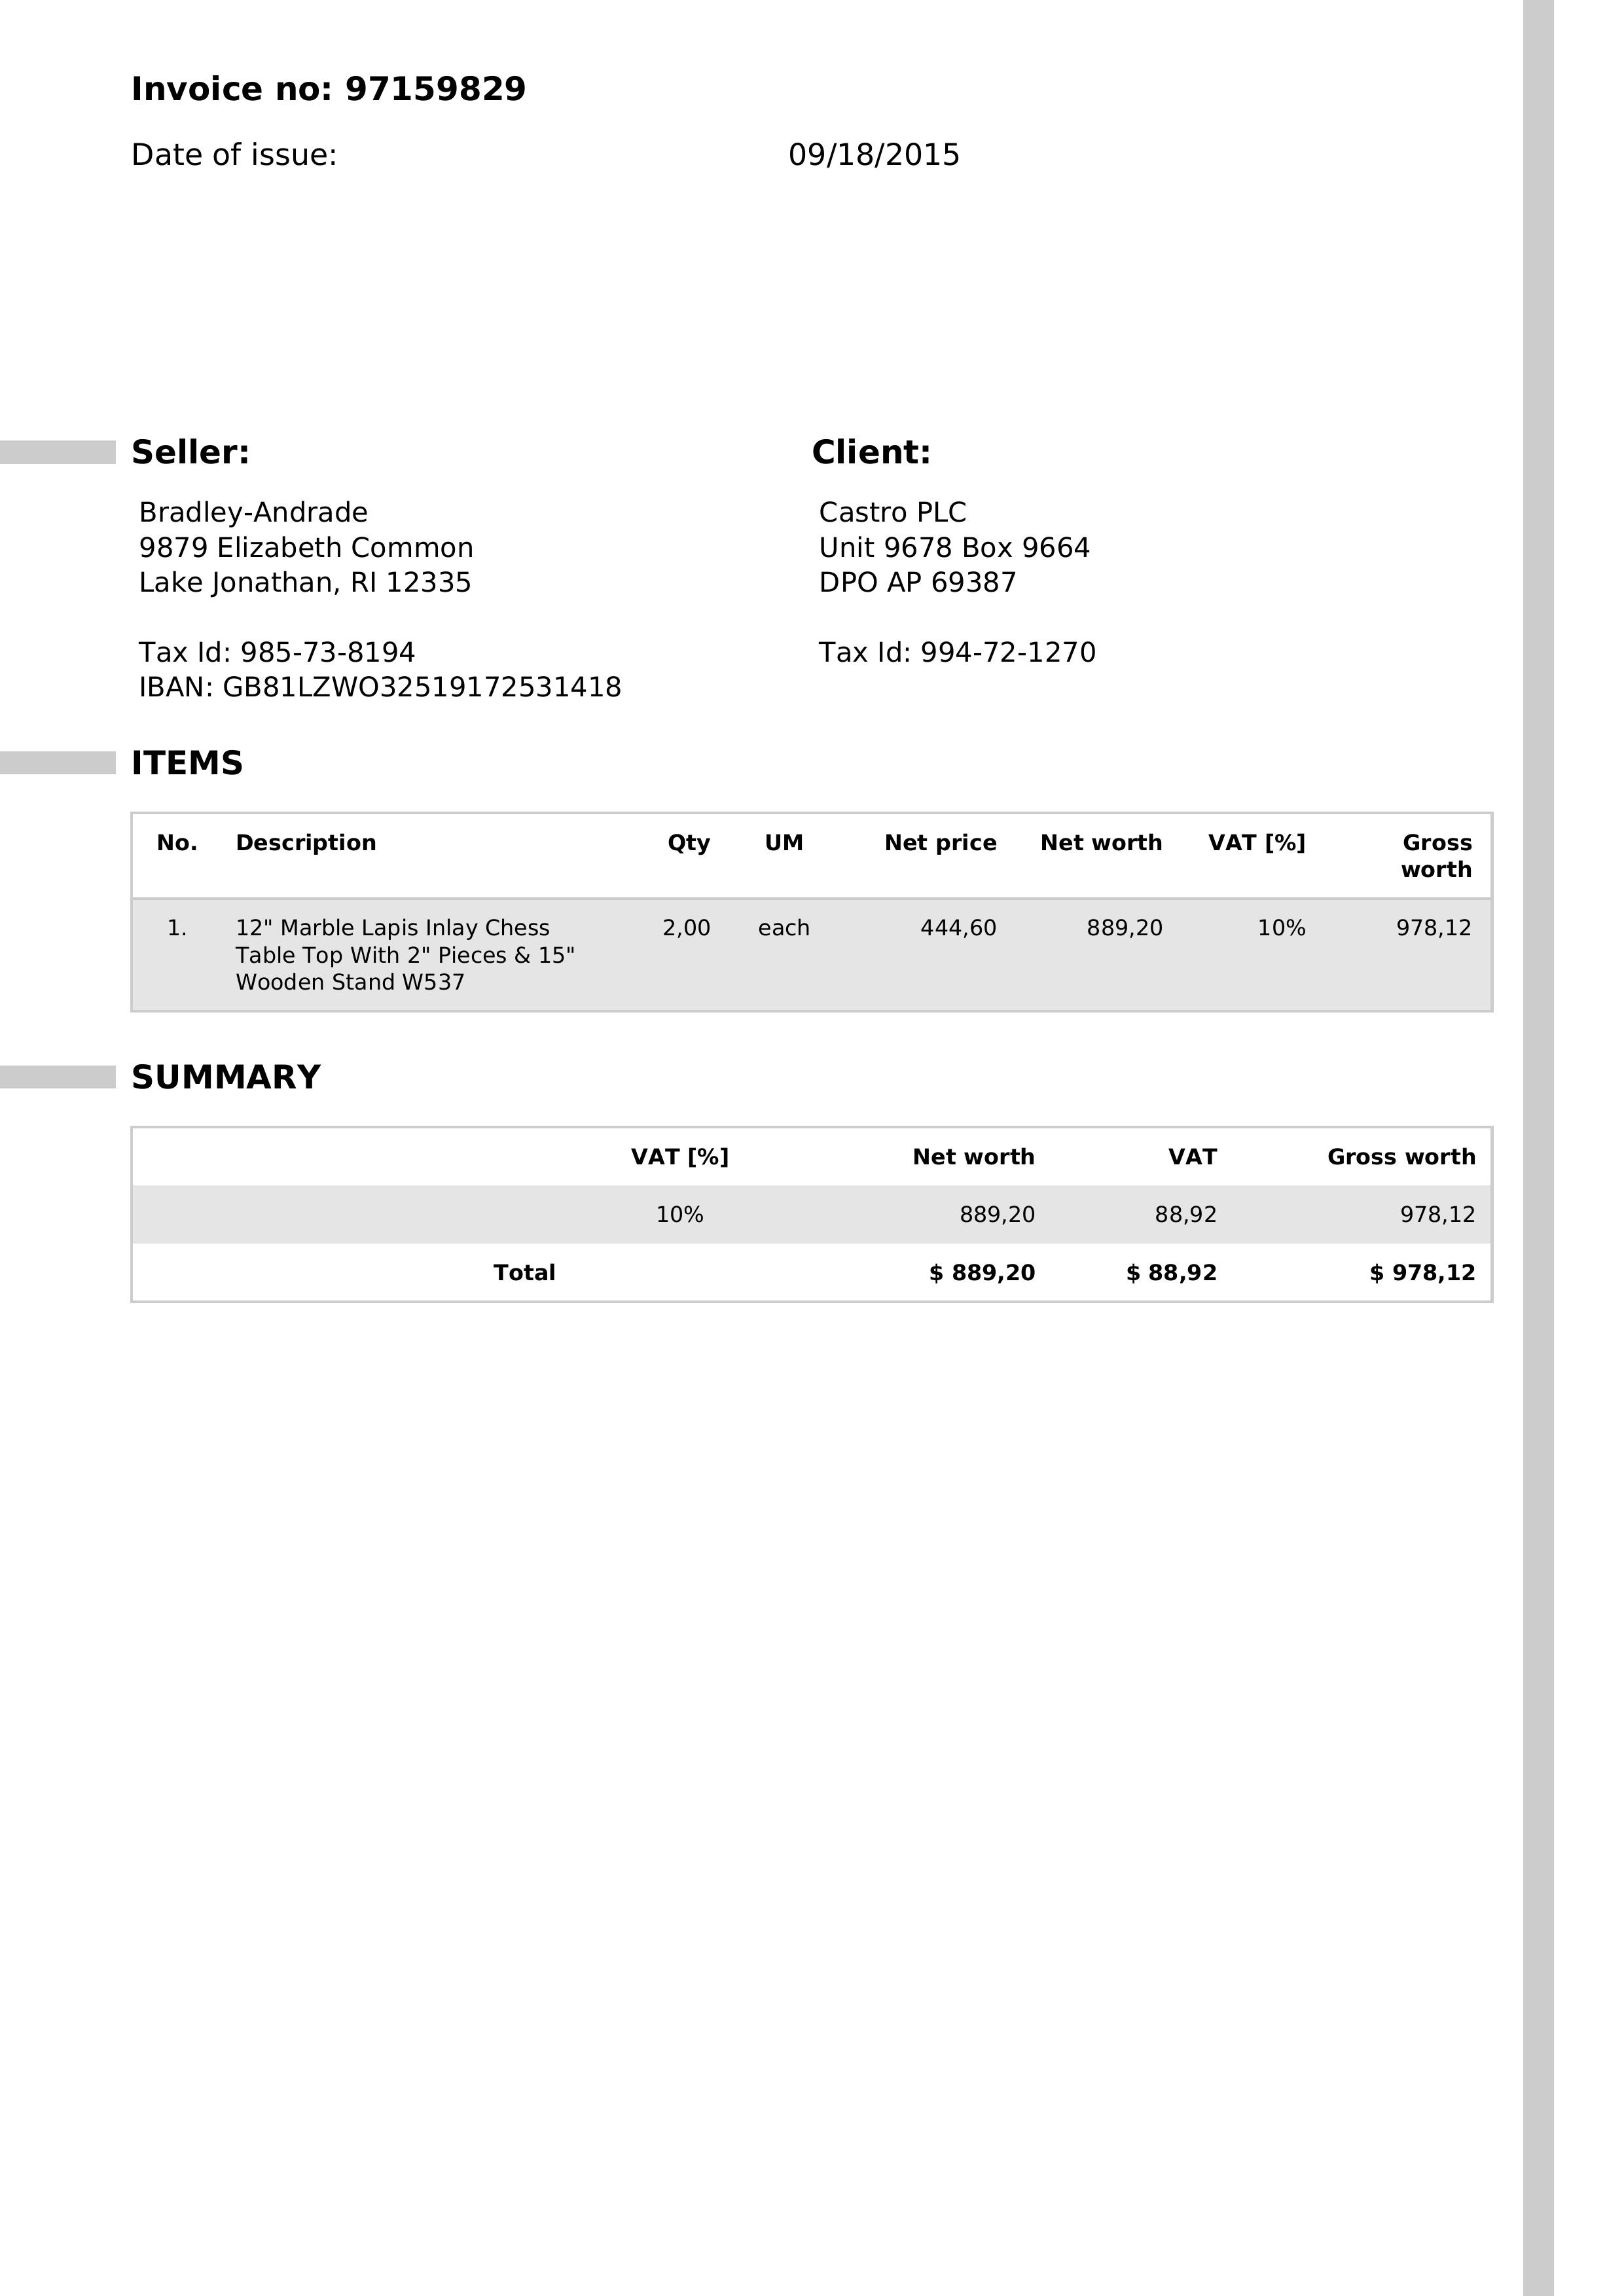

In [15]:
image = dataset['test'][0]['image']
image

## Load model and processor

In [16]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")
model = VisionEncoderDecoderModel.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [17]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 640, 480])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [18]:
import torch

task_prompt = "<s_invoices-donut-data-v1>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [19]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_invoice_no>1529<s_invoice_date> 09////</s_invoice_date> Bridge--vis 90 Elizabethmon Lakehua, RI25</s_seller> CastroLC Unit78 964PO 69</s_client> 987</s_seller> 987381<s_client_tax_id> 9972170<s_iban> GBLQZ05917514</s_iban><s_items> 17 Mar Long Boy Classics Boy Boy's Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats Soccerats</s_item_desc> 200<s_item_net_price>49400<s_item_net_worth>8920<s_item_net_worth>4920<s_item_net_worth>4920<s_item_net_worth>4920<s_item_net_worth>4920<s_item_net_worth>4920<s_item_net_worth>4912<s_item_vat><s_total_net_worth>8920<s_item_net_worth>8952<s_item_net_worth>79812</s_items><s_total_net_worth>8920<s_item_net_worth>8952<s_item_net_worth>9912</s_summary><s_item_desc></s_item_desc> $,</s_total_net_worth> $,</s_total_vat> $,</s_total_vat> $,</s_total_vat> $,</s_total_gross_worth></s_summary></s_summary></s_summary></s_summary></s

## Convert to JSON

We can convert the generated sequence to JSON if required:

In [20]:
processor.token2json(sequence)

{'invoice_date': '09////',
 'iban': 'GBLQZ05917514',
 'total_net_worth': {'item_desc': ''}}

Gradio Interface

In [2]:
%pip install gradio

  Using cached gradio-5.42.0-py3-none-any.whl (59.7 MB)
  Using cached python_multipart-0.0.20-py3-none-any.whl (24 kB)
  Using cached gradio_client-1.11.1-py3-none-any.whl (324 kB)
  Using cached fastapi-0.116.1-py3-none-any.whl (95 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached ffmpy-0.6.1-py3-none-any.whl (5.5 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl (8.7 kB)
  Using cached starlette-0.47.2-py3-none-any.whl (72 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl (66 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl (38 kB)
  Using cached groovy-0.1.2-py3-none-any.whl (14 kB)
  Using cached Brotli-1.1.0-cp310-cp310-win_amd64.whl (357 kB)
  Using cached typer-0.16.0-py3-none-any.whl (46 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached ruff-0.12.8-py3-none-win_amd64.whl (12.7 MB)
  Using cached websockets-15.0.1-cp310-cp310-win_amd64.whl (176 kB)
  Using


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr
import torch
import re
import os
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import json
from huggingface_hub import login

# Hugging Face token ile giriş
HUGGING_FACE_TOKEN = os.getenv("HUGGING_FACE_TOKEN", "your_token")
if HUGGING_FACE_TOKEN:
    login(token=HUGGING_FACE_TOKEN)

# Model ve processor'ı yükle
def load_model():
    processor = DonutProcessor.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")
    model = VisionEncoderDecoderModel.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")
    return processor, model

def process_invoice_image(image):
    """Fatura resmini işleyip JSON çıktısı döndürür"""
    try:
        # Model ve processor'ı yükle
        processor, model = load_model()
        
        # Cihaz seçimi
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)
        
        # Resmi işle
        pixel_values = processor(image, return_tensors="pt").pixel_values
        
        # Task prompt
        task_prompt = "<s_invoices-donut-data-v1>"
        decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
        
        # Model ile tahmin yap
        outputs = model.generate(
            pixel_values.to(device),
            decoder_input_ids=decoder_input_ids.to(device),
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
            output_scores=True,
        )
        
        # Çıktıyı işle
        sequence = processor.batch_decode(outputs.sequences)[0]
        sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()
        
        # JSON'a çevir
        try:
            result_json = processor.token2json(sequence)
            formatted_json = json.dumps(result_json, indent=2, ensure_ascii=False)
        except:
            # JSON çevirimi başarısız olursa ham metni döndür
            formatted_json = sequence
        
        return formatted_json, sequence
        
    except Exception as e:
        return f"Hata oluştu: {str(e)}", ""

# Gradio arayüzü
def create_interface():
    with gr.Blocks(title="Fatura Okuyucu - Donut Model", theme=gr.themes.Soft()) as interface:
        gr.Markdown("# 📄 Fatura Okuyucu Uygulaması")
        gr.Markdown("Bu uygulama Donut modelini kullanarak fatura resimlerinden bilgi çıkarır.")
        
        with gr.Row():
            with gr.Column(scale=1):
                image_input = gr.Image(
                    type="pil",
                    label="Fatura Resmi Yükleyin",
                    height=400
                )
                
                process_btn = gr.Button(
                    "Faturayı İşle", 
                    variant="primary",
                    size="lg"
                )
                
                gr.Markdown("### Desteklenen Format:")
                gr.Markdown("- PNG, JPG, JPEG dosyaları")
                gr.Markdown("- Fatura, invoice türü belgeler")
            
            with gr.Column(scale=2):
                with gr.Tabs():
                    with gr.TabItem("JSON Çıktısı"):
                        json_output = gr.Textbox(
                            label="Çıkarılan Bilgiler (JSON)",
                            lines=20,
                            max_lines=30,
                            show_copy_button=True,
                            interactive=False
                        )
                    
                    with gr.TabItem("Ham Çıktı"):
                        raw_output = gr.Textbox(
                            label="Ham Model Çıktısı",
                            lines=20,
                            max_lines=30,
                            show_copy_button=True,
                            interactive=False
                        )
        
        # Event handlers
        process_btn.click(
            fn=process_invoice_image,
            inputs=[image_input],
            outputs=[json_output, raw_output],
            show_progress=True
        )
        
        # Örnek resimler (eğer varsa)
        gr.Markdown("### 💡 Nasıl Kullanılır:")
        gr.Markdown("""
        1. Yukarıdaki alana bir fatura resmi yükleyin
        2. 'Faturayı İşle' butonuna tıklayın
        3. Model faturadan bilgileri çıkaracak ve JSON formatında gösterecek
        4. Çıktıları kopyalayabilir veya indirebilirsiniz
        """)
    
    return interface

if __name__ == "__main__":
    # Arayüzü oluştur ve başlat
    interface = create_interface()
    interface.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7860,
        show_error=True
    )


* Running on local URL:  http://0.0.0.0:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
